# Explanation:
<br>

## architecture:

> This project presents a CNN architecture that uses MRI data from the ADNI dataset to classify Alzheimer’s disease. The network leverages different CNN models, filter sizes, and pooling layers to extract features from MRI images, enabling precise classification of AD subtypes and stages. Accurate classification can aid in early detection, personalized treatment planning, disease monitoring, and prognostic assessment, showcasing the potential of this CNN architecture to assist medical professionals and researchers in making informed decisions about AD patients.



## what is Alzheimer's disease (AD)?

> Alzheimer's disease (AD) is a common brain ailment leading to memory loss and cognitive decline, ranking as a significant cause of mortality.

## what is MCI?

> Mild cognitive impairment (MCI) lies between normal brain function and AD, with AD progressing from the prodromal stage of MCI to dementia. Identifying MCI early can help delay or prevent the progression to AD, with studies showing a 10-15% annual development rate from MCI to AD. Intermediate MCI stages show subtle brain lesion variations.



> Early mild cognitive impairment (EMCI) emerges in the initial phase of MCI, while late mild cognitive impairment (LMCI) or progressive MCI (PMCI) indicates worsening symptoms over time. As symptoms evolve, transitioning between stages requires careful monitoring by medical professionals. Researchers face challenges in identifying distinct symptoms across different sets. Medical imaging techniques like PET, MRI, and CT provide crucial standardized testing and images for experimental processes in this field.



## Features extracted from MRI

> MRI is a widely recognized and versatile tool for diagnosing various diseases such as brain tumors, neurological disorders, spinal cord injuries, and liver diseases. Its high sensitivity allows for early disease detection. Different MRI sequences are suited for different disorders, and MRI images are frequently used for Alzheimer's disease classification. Features extracted from MRI images, **such as grey and white matter volumes, cortical thickness, and CSF levels, aid in categorizing and diagnosing mild cognitive impairment or Alzheimer's disease**. Pre-trained CNNs show promise in automatically diagnosing cognitive illnesses from brain MRI images.

# connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your dataset
dataset_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

# import libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import random
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt


# Image preprocessing
1. split dataset
2. normalize images

# Step 1: Modify the Dataset Preparation


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return np.array([os.path.join(directory, image) for image in os.listdir(directory)])

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Combine all images and labels
all_images = np.concatenate([ad_images, mci_images])
all_labels = np.concatenate([ad_labels, mci_labels])

# Split the dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


# Step 2: Modify the Image Data Generators


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import random
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Define paths
parent_dir = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset'

# Initialize the ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of data for validation
)

# Create training data generator
train_generator = datagen.flow_from_directory(
    directory=parent_dir,
    classes=['AD', 'MCI'],
    class_mode='binary',
    batch_size=32,
    target_size=(256, 256),
    subset='training'
)

# Create validation data generator
validation_generator = datagen.flow_from_directory(
    directory=parent_dir,
    classes=['AD', 'MCI'],
    class_mode='binary',
    batch_size=32,
    target_size=(256, 256),
    subset='validation'
)

# Create test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=parent_dir,
    classes=['AD', 'MCI'],
    class_mode='binary',
    batch_size=32,
    target_size=(256, 256)
)

# Check the distribution of classes in each split
print("Training set - AD: {}, MCI: {}".format(np.sum(train_generator.labels == 0), np.sum(train_generator.labels == 1)))
print("Validation set - AD: {}, MCI: {}".format(np.sum(validation_generator.labels == 0), np.sum(validation_generator.labels == 1)))
print("Testing set - AD: {}, MCI: {}".format(np.sum(test_generator.labels == 0), np.sum(test_generator.labels == 1)))


Found 1332 images belonging to 2 classes.
Found 332 images belonging to 2 classes.
Found 1664 images belonging to 2 classes.
Training set - AD: 780, MCI: 552
Validation set - AD: 195, MCI: 137
Testing set - AD: 975, MCI: 689


**Update Data Generators with Validation Split:**

# Step 3: Modify the Display Function to Use NumPy Arrays


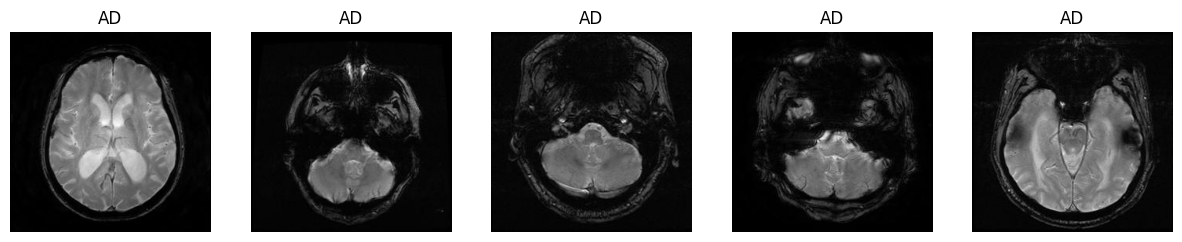

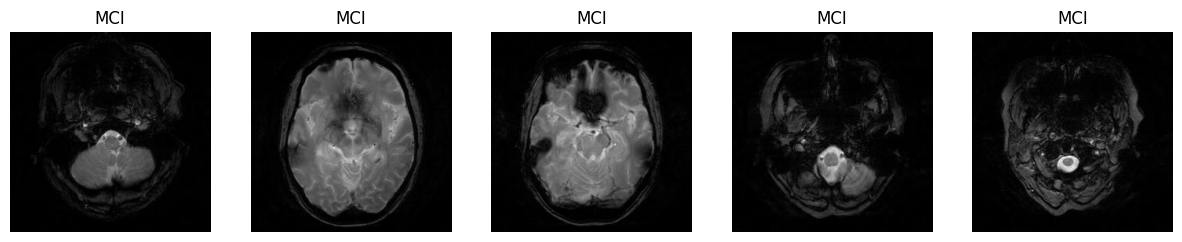

In [ ]:
# Display example images from AD and MCI datasets
num_examples = 5  # Number of examples to display

# Function to display example images
def display_examples(image_paths, dataset_name):
    plt.figure(figsize=(15, 3))
    for i in range(num_examples):
        image = cv2.imread(image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(dataset_name)
    plt.show()

# Display example images from AD dataset
display_examples(ad_images, 'AD')

# Display example images from MCI dataset
display_examples(mci_images, 'MCI')


# Data augmentation

To expand the primary dataset as per the specified image modes, resulting in a fivefold increase in data volume. This augmentation will yield an additional four images from each original photo.

The proposed CNN framework is designed for end-to-end AD classification, starting from image acquisition to classification. It incorporates
1. adaptive thresholding,
2. data augmentation,
3. Glorot Uniform weight initializer,
4. and the Adam optimizer
<br>
to enhance **performance**.


> Data Augmentation: To expand the training dataset and improve the model's accuracy, data augmentation is performed. The framework applies various augmentation factors such as horizontal flipping, shearing, shifting, rotating, and zooming to create new and different training examples.

In the paper "A CNN based framework for classification of Alzheimer’s disease," the authors describe their preprocessing and augmentation steps as part of their end-to-end framework for classifying Alzheimer's disease using MRI scans. Here's how they preprocess and augment the data:

1. **Acquisition and Annotation**: The first step is to acquire MRI images in the '.nii' format and convert them to '.png' files. Only images containing the full shape of the brain are used, and they are annotated with classes to facilitate future processing.

2. **Preprocessing and Augmentation**: This layer takes the annotated images as input and applies several preprocessing steps:

   - **Grayscale Conversion**: The images are converted to grayscale.
   - **Adaptive Thresholding**: Instead of using a global threshold for all pixels, the threshold is dynamically changed over the image to handle varying lighting conditions.
   - **Cropping and Filtration**: The images are cropped and filtered to generate grayscale images of size (256, 256).
   - **Resizing**: A transformer is used to resize the produced images to (128, 128) and (64, 64).

3. **Data Augmentation**: To expand the training dataset and improve the model's accuracy, data augmentation is performed. The framework applies various augmentation factors such as horizontal flipping, shearing, shifting, rotating, and zooming to create new and different training examples.

4. **Cross-validation**: The dataset is divided into training, validation, and testing sets. The training set is further divided into training and validation subsets to avoid overfitting and to obtain the best values for training parameters.

5. **CNN Model**: The CNN architecture consists of three convolutional layers, with max-pooling after each layer. The model uses activation functions like ReLU and SoftMax for the output layer to enhance the classification process.

6. **Classification Layer**: The Glorot Uniform weight initializer is used to initialize the network weights, and the Adam optimizer is applied in the optimization process to achieve quicker convergence.

The paper emphasizes the importance of these preprocessing and augmentation steps in improving the performance of the CNN model for classifying Alzheimer's disease from MRI scans.

Training set - AD: 3148, MCI: 2176
Testing set - AD: 961, MCI: 703
Validation set - AD: 766, MCI: 566


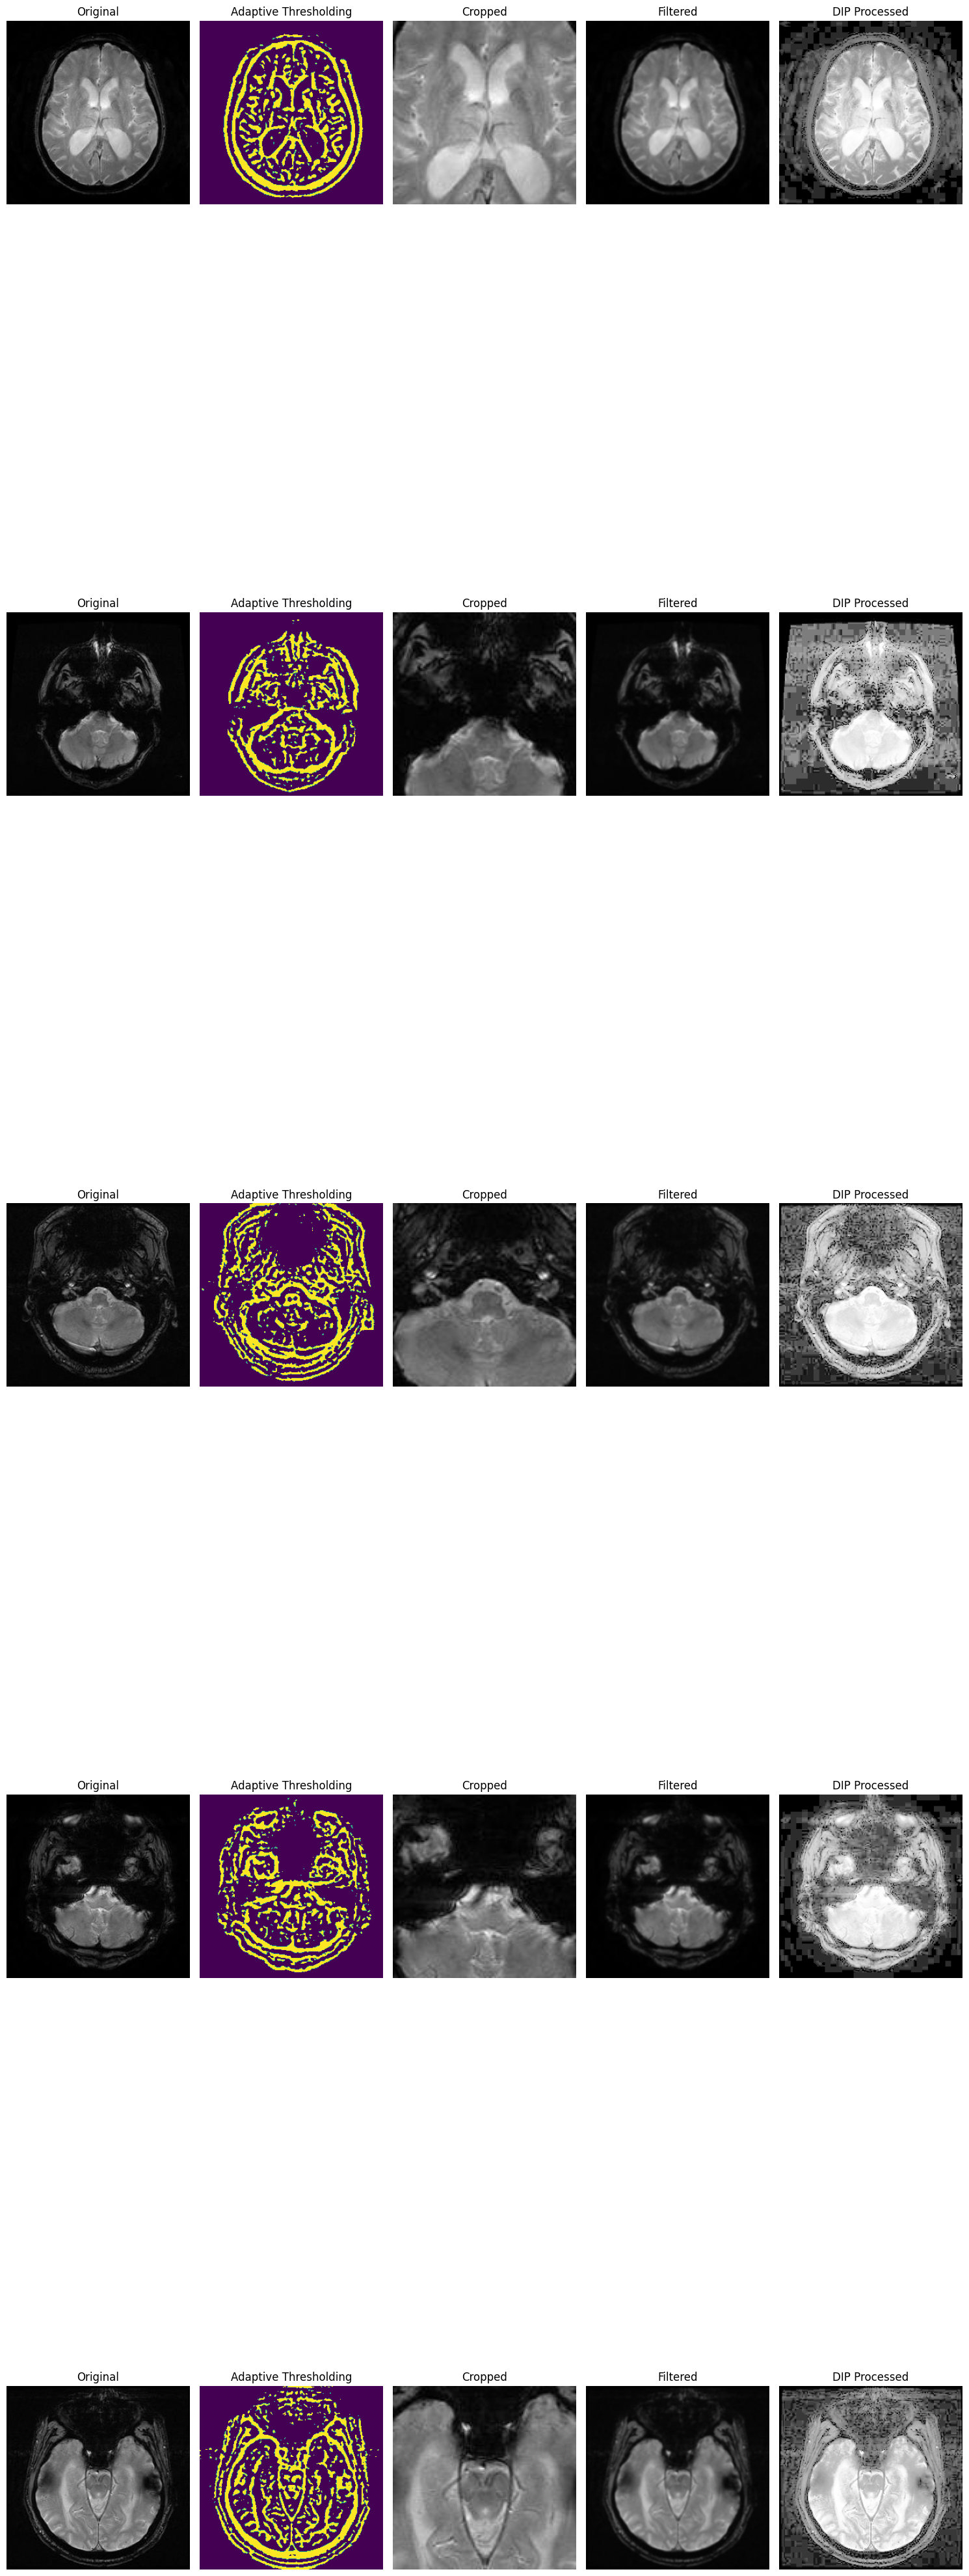

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return [os.path.join(directory, image) for image in os.listdir(directory) if image.endswith('.jpg') or image.endswith('.png')]

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Combine all images and labels
all_images = ad_images + mci_images
all_labels = np.concatenate([ad_labels, mci_labels])

# Function to apply augmentation to an image
def augment_image(image_path):
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not loaded properly from path: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

        # Adaptive thresholding
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

        # Cropping
        height, width, _ = image.shape
        cropped = image[max(0, height//4):min(height, height//4*3), max(0, width//4):min(width, width//4*3), :]  # Crop center 50%

        # Filtration (Gaussian blur)
        filtered = cv2.GaussianBlur(image, (5, 5), 0)

        # DIP (Digital Image Processing) operation (histogram equalization)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
        dip_processed = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

        # Combine all augmented images
        augmented_images = [image, thresholded, cropped, filtered, dip_processed]

        return augmented_images
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return []

# Augment all images in the dataset
augmented_data = []
for image_path, label in zip(all_images, all_labels):
    augmentations = augment_image(image_path)
    for augmented_image in augmentations:
        augmented_data.append((augmented_image, label))

# Separate augmented images and labels
augmented_images = [pair[0] for pair in augmented_data]
augmented_labels = np.array([pair[1] for pair in augmented_data])

# Split the augmented dataset into training, testing, and validation sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42)

# Normalize the augmented images
def normalize_image(image):
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize pixel values between 0 and 1
    return image

# Apply normalization to all splits
X_train_aug = [normalize_image(image) for image in X_train_aug]
X_test_aug = [normalize_image(image) for image in X_test_aug]
X_val_aug = [normalize_image(image) for image in X_val_aug]

# Check the distribution of classes in each split
print("Training set - AD: {}, MCI: {}".format(np.sum(y_train_aug == 0), np.sum(y_train_aug == 1)))
print("Testing set - AD: {}, MCI: {}".format(np.sum(y_test_aug == 0), np.sum(y_test_aug == 1)))
print("Validation set - AD: {}, MCI: {}".format(np.sum(y_val_aug == 0), np.sum(y_val_aug == 1)))

# Choose multiple example images for demonstration (e.g., first 3 images)
num_examples = 5
example_images = all_images[:num_examples]

# Display original images and augmented versions for each example
plt.figure(figsize=(15, 10 * num_examples))
for idx, image_path in enumerate(example_images):
    augmented_images = augment_image(image_path)
    for i, image in enumerate(augmented_images):
        plt.subplot(num_examples, 5, idx * 5 + i + 1)
        plt.imshow(image)
        plt.title(["Original", "Adaptive Thresholding", "Cropped", "Filtered", "DIP Processed"][i])
        plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform, exposure

# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return [os.path.join(directory, image) for image in os.listdir(directory)]

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Combine all images and labels
all_images = ad_images + mci_images
all_labels = np.concatenate([ad_labels, mci_labels])

# Function to apply augmentation to an image
def augment_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

    # Adaptive thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Cropping
    cropped = image[50:150, 50:150, :]  # Example: crop from (50,50) to (150,150)

    # Filtration (Gaussian blur)
    filtered = cv2.GaussianBlur(image, (5, 5), 0)

    # DIP (Digital Image Processing) operation (histogram equalization)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    dip_processed = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Combine all augmented images
    augmented_images = [image, thresholded, cropped, filtered, dip_processed]

    return augmented_images

# Augment all images in the dataset
augmented_data = []
for image_path, label in zip(all_images, all_labels):
    augmentations = augment_image(image_path)
    for augmented_image in augmentations:
        augmented_data.append((augmented_image, label))

# Separate augmented images and labels
augmented_images = [pair[0] for pair in augmented_data]
augmented_labels = np.array([pair[1] for pair in augmented_data])

# Split the augmented dataset into training, testing, and validation sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42)

# Normalize the augmented images (You should replace this with your actual normalization code)
def normalize_image(image):
    image = image / 255.0  # Normalize pixel values between 0 and 1
    return image

# Apply normalization to all splits
X_train_aug = [normalize_image(image) for image in X_train_aug]
X_test_aug = [normalize_image(image) for image in X_test_aug]
X_val_aug = [normalize_image(image) for image in X_val_aug]

# Check the distribution of classes in each split
print("Training set - AD: {}, MCI: {}".format(np.sum(y_train_aug == 0), np.sum(y_train_aug == 1)))
print("Testing set - AD: {}, MCI: {}".format(np.sum(y_test_aug == 0), np.sum(y_test_aug == 1)))
print("Validation set - AD: {}, MCI: {}".format(np.sum(y_val_aug == 0), np.sum(y_val_aug == 1)))


Training set - AD: 610, MCI: 454
Validation set - AD: 160, MCI: 106
Testing set - AD: 204, MCI: 129


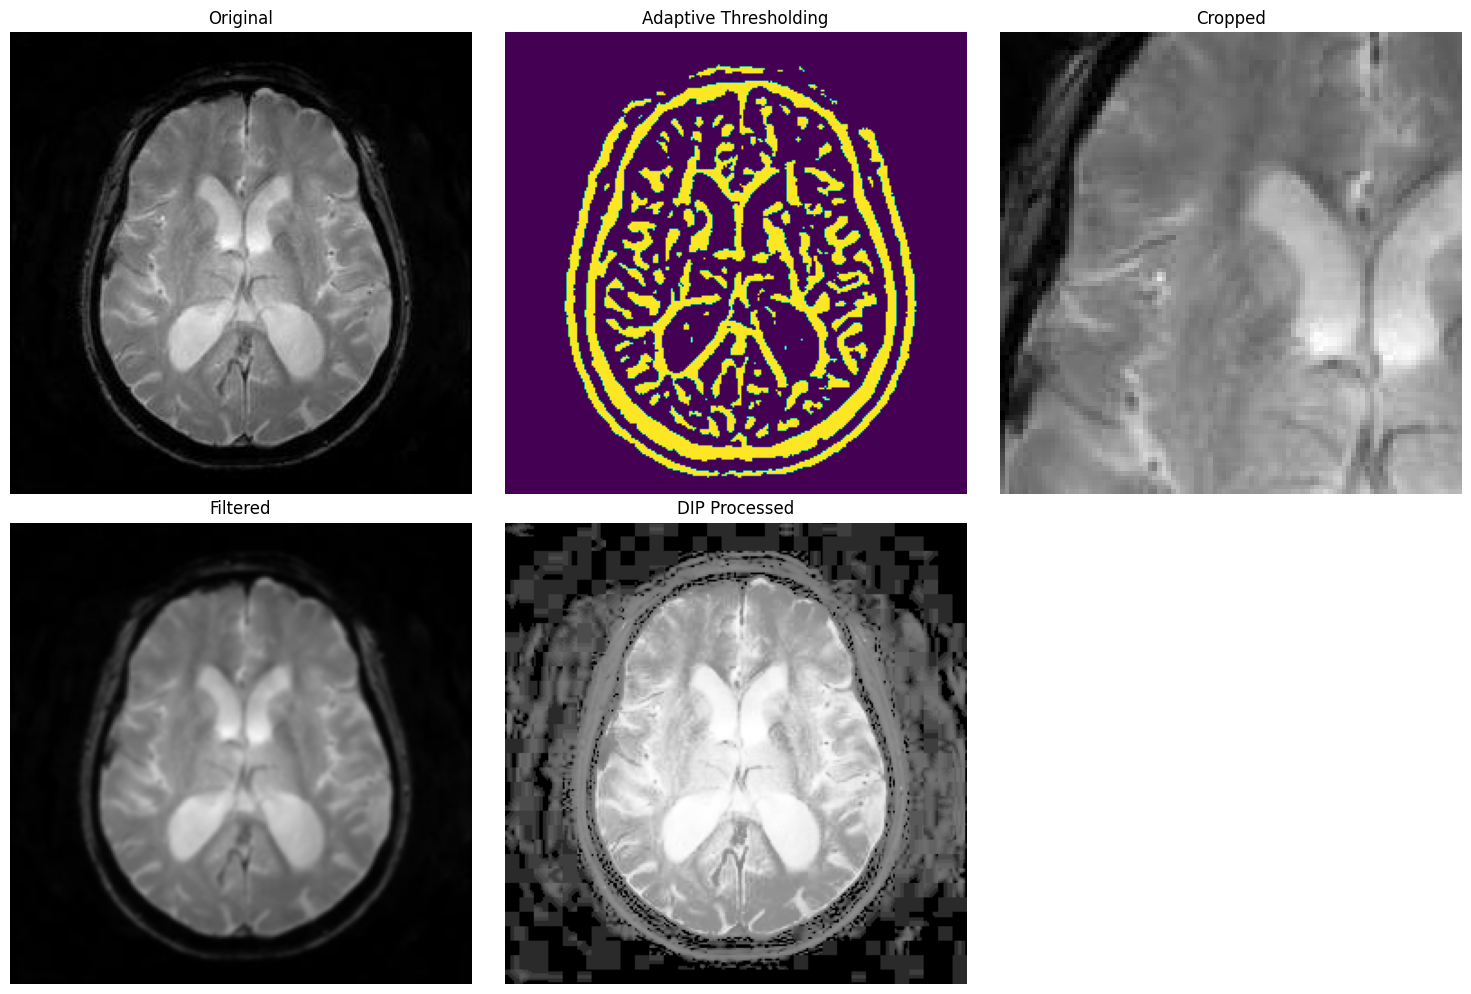

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform, exposure
import matplotlib.pyplot as plt

# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return [os.path.join(directory, image) for image in os.listdir(directory)]

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Combine all images and labels
all_images = ad_images + mci_images
all_labels = np.concatenate([ad_labels, mci_labels])

# Function to apply augmentation to an image
def augment_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

    # Adaptive thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Cropping
    cropped = image[50:150, 50:150, :]  # Example: crop from (50,50) to (150,150)

    # Filtration (Gaussian blur)
    filtered = cv2.GaussianBlur(image, (5, 5), 0)

    # DIP (Digital Image Processing) operation (histogram equalization)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    dip_processed = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Combine all augmented images with labels
    augmented_images = [
        (image, "Original"),
        (thresholded, "Adaptive Thresholding"),
        (cropped, "Cropped"),
        (filtered, "Filtered"),
        (dip_processed, "DIP Processed")
    ]

    return augmented_images

# Choose an example image for demonstration
example_image_path = all_images[0]
augmented_images = augment_image(example_image_path)

# Display original image and augmented versions
plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(augmented_images):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform, exposure
import matplotlib.pyplot as plt

# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return [os.path.join(directory, image) for image in os.listdir(directory)]

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Combine all images and labels
all_images = ad_images + mci_images
all_labels = np.concatenate([ad_labels, mci_labels])

# Function to apply augmentation to an image
def augment_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB

    # Adaptive thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

    # Cropping
    cropped = image[50:150, 50:150, :]  # Example: crop from (50,50) to (150,150)

    # Filtration (Gaussian blur)
    filtered = cv2.GaussianBlur(image, (5, 5), 0)

    # DIP (Digital Image Processing) operation (histogram equalization)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
    dip_processed = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Combine all augmented images with labels
    augmented_images = np.array(
        (image, "Original"),
        (thresholded, "Adaptive Thresholding"),
        (cropped, "Cropped"),
        (filtered, "Filtered"),
        (dip_processed, "DIP Processed")
    )

    return augmented_images

# Choose multiple example images for demonstration (e.g., first 3 images)
num_examples = 5
example_images = all_images[:num_examples]

# Display original images and augmented versions for each example
plt.figure(figsize=(15, 10 * num_examples))
for idx, image_path in enumerate(example_images):
    augmented_images = augment_image(image_path)
    for i, (image, label) in enumerate(augmented_images):
        plt.subplot(num_examples, 5, idx * 5 + i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')

plt.tight_layout()
plt.show()


TypeError: array() takes from 1 to 2 positional arguments but 5 were given

<Figure size 1500x5000 with 0 Axes>

### Explanation:
1. Looping Through Example Images:

  num_examples determines how many examples (images) you want to display. Here, num_examples = 3 means we'll display the first 3 images from the dataset.
2. Displaying Multiple Examples:

  The outer loop (for idx, image_path in enumerate(example_images)) iterates through each example image.
  For each example image, the augment_image function is called to generate its augmented versions.
  The inner loop (for i, (image, label) in enumerate(augmented_images)) iterates through each augmented image of the current example and displays it.
3. Layout and Visualization:

  plt.subplot(num_examples, 5, idx * 5 + i + 1) calculates the correct position in the grid for each image based on the number of examples (num_examples) and the number of augmentations (5 augmentations per image).
4. Output:

- Displays a grid of images where each row corresponds to an example image and each column (except the first) shows a different augmentation type.
This code snippet will allow you to visualize multiple examples of original images along with their augmented versions, helping you understand how each augmentation technique affects different images in your dataset. Adjust num_examples as needed to display more or fewer examples.

# Glorot initialization
 also known as Xavier initialization, is a method used to initialize the weights of a neural network. It is named after Xavier Glorot, who introduced the technique in his paper "Understanding the difficulty of training deep feedforward neural networks" in 2010.

According to the article "A CNN based framework for classification of Alzheimer’s disease," Glorot initialization is used to initialize the network weights in such a way that the neuron activation functions do not start in saturated or dead regions. This leads to quicker convergence and higher accuracy during the training process.

The Glorot initialization method involves initializing the weights with a uniform distribution between -sqrt(6/nIN+nOUT) and sqrt(6/nIN+nOUT) where nIN is the number of inputs to the layer and nOUT is the number of outputs from the layer. This range of values helps to maintain the variance of the outputs in the network close to the variance of its inputs, which is important for efficient learning.

In the context of the article, Glorot initialization is one of the key components of the proposed CNN framework, contributing to the model's ability to achieve high classification accuracy in distinguishing between different stages of Alzheimer's disease using MRI data.

# Table 9

 in the article "A CNN based framework for classification of Alzheimer’s disease" presents three different architectures used in the study: the proposed model, testing model 1, and testing model 2. Each architecture is defined by its layer hierarchy, shape, and number of filters. Here's a breakdown of each model:

1. **Proposed Model**:
   - **CONV**: The first convolutional layer with a shape of 64x64 and 32 filters of size 3x3.
   - **CONV**: A second convolutional layer with the same shape and number of filters.
   - **MAX_POOL**: A max-pooling layer with a shape of 32x32.
   - **CONV**: A third convolutional layer with the same shape and number of filters.
   - **CONV**: A fourth convolutional layer with the same shape and number of filters.
   - **MAX_POOL**: Another max-pooling layer.
   - **FLATTEN**: Flattens the output of the max-pooling layer.
   - **DENSE**: A fully connected layer with 128 neurons.
   - **DENSE**: Another fully connected layer with 64 neurons.
   - **DENSE**: The final fully connected layer with 2 neurons for binary classification.

2. **Testing Model 1**:
   - **CONV**: A convolutional layer with a shape of 64x64 and 32 filters of size 3x3.
   - **MAX_POOL**: A max-pooling layer.
   - **CONV**: A second convolutional layer with the same shape and number of filters.
   - **MAX_POOL**: Another max-pooling layer.
   - **FLATTEN**: Flattens the output.
   - **DENSE**: A fully connected layer with 128 neurons.
   - **DENSE**: The final fully connected layer with 2 neurons.

3. **Testing Model 2**:
   - **CONV**: A convolutional layer with a shape of 64x64 and 32 filters of size 3x3.
   - **CONV**: A second convolutional layer with the same shape and number of filters.
   - **MAX_POOL**: A max-pooling layer.
   - **FLATTEN**: Flattens the output.
   - **DENSE**: A fully connected layer with 128 neurons.
   - **DENSE**: Another fully connected layer with 64 neurons.
   - **DENSE**: The final fully connected layer with 2 neurons.

The proposed model is the main architecture used in the study, and it includes more convolutional layers compared to the testing models. This suggests that the proposed model has a deeper architecture, which can potentially capture more complex features from the MRI images. The testing models are likely used for comparison purposes to evaluate the performance of the proposed model.

It's important to note that the actual performance of these models is not discussed in the summary provided, so the effectiveness of each architecture in classifying Alzheimer's disease would need to be assessed by reviewing the full article and its experimental results.

## Step 1: Data Preparation and Augmentation


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform, exposure
import matplotlib.pyplot as plt


In [ ]:
# Path to the directories containing the AD and MCI images
ad_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/AD'
mci_path = '/content/drive/My Drive/Deep learning/Alzheimer_s_Disease_Neuroimaging_ADNI_Dataset/MCI'

# Function to get the list of image file paths in a directory
def get_image_paths(directory):
    return [os.path.join(directory, image) for image in os.listdir(directory)]

# Function to load and resize an image
def load_and_resize_image(image_path, target_size=(64, 64)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
    image = cv2.resize(image, target_size)  # Resize image
    return image

# Function to apply augmentation to an image
def augment_image(image):
    # Example augmentations
    # Add your augmentation techniques here
    return [image]  # Return list of augmented images

# Get the list of image file paths for AD and MCI images
ad_images = get_image_paths(ad_path)
mci_images = get_image_paths(mci_path)

# Combine image paths with labels for original data
ad_labels = np.zeros(len(ad_images))
mci_labels = np.ones(len(mci_images))

# Load and resize original images
original_data = []
for image_path, label in zip(ad_images + mci_images, ad_labels.tolist() + mci_labels.tolist()):
    image = load_and_resize_image(image_path)
    original_data.append((image, label))

# Separate original images and labels
original_images = np.array([pair[0] for pair in original_data])
original_labels = np.array([pair[1] for pair in original_data])

# Augment all images in the dataset
augmented_data = []
for image_path, label in zip(ad_images + mci_images, ad_labels.tolist() + mci_labels.tolist()):
    image = load_and_resize_image(image_path)
    augmentations = augment_image(image)
    for augmented_image in augmentations:
        augmented_data.append((augmented_image, label))

# Separate augmented images and labels
augmented_images = np.array([pair[0] for pair in augmented_data])
augmented_labels = np.array([pair[1] for pair in augmented_data])

# Combine augmented and original datasets
X_combined = np.concatenate([original_images, augmented_images], axis=0)
y_combined = np.concatenate([original_labels, augmented_labels], axis=0)

# Split the combined dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

## Step 2: Define the CNN Model


## Proposed model

In [ ]:
# Define the model architecture
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),

    # Second convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

    # Fourth convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

    # Second max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    # Output layer for binary classification (AD or MCI)
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                   

In [ ]:
# Fit the model
history = model.fit(X_train_aug, y_train_aug,
                    epochs=1,
                    batch_size=32,
                    validation_data=(X_val_aug, y_val_aug))


NameError: name 'X_train_aug' is not defined

## Step 4: Evaluate and Visualize Training Results


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Testing model 1

In [ ]:

# Define Testing Model 1 architecture
model_testing1 = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),

    # Second max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification (2 classes)
])


In [ ]:
# Compile the model
model_testing1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing1.summary()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on test data
loss, accuracy = model_testing1.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Predict classes for test set
y_pred = model_testing1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes
y_true = y_test.astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Testing model 2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define Testing Model 2 architecture
model_testing2 = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),

    # Second convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),

    # Output layer with 2 neurons for binary classification
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification (2 classes)
])




In [ ]:
# Compile the model
model_testing2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing2.summary()


### Explanation:
- **Model Architecture**:
  - **Convolutional Layers**: Two convolutional layers (`Conv2D`) with 32 filters of size 3x3. The first layer takes input of shape (64, 64, 3).
  - **MaxPooling Layer**: One max-pooling layer (`MaxPooling2D`) with pool size of 2x2.
  - **Flatten Layer**: Flattens the output from the convolutional layers into a 1D array.
  - **Dense Layers**: Two fully connected dense layers (`Dense`) with 128 and 64 neurons respectively. The final layer uses `softmax` activation suitable for multi-class classification with 2 output classes.

- **Compilation**:
  - Uses `adam` optimizer, which is efficient and widely used.
  - Loss function `sparse_categorical_crossentropy` is suitable for multi-class classification tasks where the labels are integers.

- **Summary**: Prints out a summary of the model architecture, displaying layer types, output shapes, and number of parameters.

Now, you can proceed to train (`fit`), evaluate, and visualize the performance of `model_testing2` similarly as shown earlier for `model_testing1`. Adjust the input shape, optimizer, loss function, and other parameters as per your specific requirements and dataset characteristics.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on test data
loss, accuracy = model_testing2.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Predict classes for test set
y_pred = model_testing2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True classes
y_true = y_test.astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## added categorical cross entropy

## test1

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding for model_testing1
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Define Testing Model 1 architecture with categorical crossentropy
model_testing1 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  # Output layer with softmax for 2 classes
])

# Compile the model with categorical crossentropy
model_testing1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing1.summary()


## test2

In [ ]:
# Convert labels to one-hot encoding for model_testing2
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

# Define Testing Model 2 architecture with categorical crossentropy
model_testing2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')  # Output layer with softmax for 2 classes
])

# Compile the model with categorical crossentropy
model_testing2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing2.summary()


## Evaluate and Visualize Models


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate model_testing1 with categorical crossentropy
loss1, accuracy1 = model_testing1.evaluate(X_test, y_test_onehot)
print(f"Testing Model 1 with Categorical Crossentropy:")
print(f"Test Loss: {loss1:.4f}")
print(f"Test Accuracy: {accuracy1*100:.2f}%")

# Predict classes for model_testing1
y_pred1 = model_testing1.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis=1)

# Print classification report for model_testing1
print("\nClassification Report for Testing Model 1:")
print(classification_report(y_test, y_pred_classes1))

# Plot confusion matrix for model_testing1
cm1 = confusion_matrix(y_test, y_pred_classes1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Testing Model 1')
plt.show()

# Evaluate model_testing2 with categorical crossentropy
loss2, accuracy2 = model_testing2.evaluate(X_test, y_test_onehot)
print(f"\nTesting Model 2 with Categorical Crossentropy:")
print(f"Test Loss: {loss2:.4f}")
print(f"Test Accuracy: {accuracy2*100:.2f}%")

# Predict classes for model_testing2
y_pred2 = model_testing2.predict(X_test)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Print classification report for model_testing2
print("\nClassification Report for Testing Model 2:")
print(classification_report(y_test, y_pred_classes2))

# Plot confusion matrix for model_testing2
cm2 = confusion_matrix(y_test, y_pred_classes2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Testing Model 2')
plt.show()




### Comparison:

This code snippet performs the following tasks:
- **Model Evaluation**: Evaluates `model_testing1` and `model_testing2` using `categorical_crossentropy` loss on the test set (`X_test`, `y_test_onehot`).
- **Prediction and Classification Report**: Predicts classes (`y_pred_classes1`, `y_pred_classes2`) and generates classification reports using `classification_report` from `sklearn.metrics`.
- **Confusion Matrix**: Computes and visualizes confusion matrices (`cm1`, `cm2`) using `confusion_matrix` from `sklearn.metrics` and plots them using `seaborn` and `matplotlib`.

Make sure `X_test` is properly preprocessed (normalized, resized, etc.) before running the evaluation code. This setup allows you to compare the performance of both models (`model_testing1` and `model_testing2`) when using `categorical_crossentropy` loss. Adjust the plotting and visualization parameters (`cmap`, `xticklabels`, `yticklabels`, etc.) as per your preference.

# Visualizing Accuracy and Loss (Error) Graphs


In [ ]:
import matplotlib.pyplot as plt

# Train both models
history1 = model_testing1.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val, y_val_onehot))
history2 = model_testing2.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val, y_val_onehot))

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Training Accuracy', linestyle='--', marker='o', color='b')
plt.plot(history1.history['val_accuracy'], label='Model 1 Validation Accuracy', linestyle='-', marker='o', color='b')
plt.plot(history2.history['accuracy'], label='Model 2 Training Accuracy', linestyle='--', marker='o', color='r')
plt.plot(history2.history['val_accuracy'], label='Model 2 Validation Accuracy', linestyle='-', marker='o', color='r')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Training Loss', linestyle='--', marker='o', color='b')
plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss', linestyle='-', marker='o', color='b')
plt.plot(history2.history['loss'], label='Model 2 Training Loss', linestyle='--', marker='o', color='r')
plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss', linestyle='-', marker='o', color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ROC Curve


In [ ]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot ROC curve for model_testing1
plot_roc_curve(model_testing1, X_test, y_test)

# Plot ROC curve for model_testing2
plot_roc_curve(model_testing2, X_test, y_test)




### Explanation:

- **ROC Curve**:
  - The `plot_roc_curve` function calculates the ROC curve for a given model (`model`) using `predict_proba` to get predicted probabilities (`y_pred_prob`).
  - `roc_curve` computes the false positive rate (`fpr`) and true positive rate (`tpr`) for different threshold values.
  - `auc` computes the Area Under the Curve (AUC) for the ROC curve.
  - The ROC curve and the AUC value are plotted using `matplotlib`.

- **Visualization**:
  - Two ROC curves are plotted, one for `model_testing1` and another for `model_testing2`, allowing you to compare their performance in terms of discrimination between the two classes ('AD' and 'MCI').

### Analysis:

- **Accuracy and Loss Graphs**:
  - Analyze the trend of accuracy and loss over epochs to understand how well each model is training and whether there are signs of overfitting or underfitting.
  
- **ROC Curve**:
  - Analyze the ROC curve and AUC value to evaluate the discriminatory power of each model. A higher AUC indicates better performance in distinguishing between 'AD' and 'MCI' classes.

These visualizations provide comprehensive insights into the performance and behavior of `model_testing1` and `model_testing2`, both in terms of training dynamics (accuracy and loss) and discriminatory power (ROC curve). Adjust parameters and plotting styles as needed for your specific analysis and presentation requirements.

# Import Required Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import seaborn as sns


# Define Function to Calculate Metrics


In [ ]:
def calculate_metrics(model, X, y_true):
    # Predict classes
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)

    # Calculate AUC
    y_pred_prob = model.predict_proba(X)
    roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    return accuracy, precision, recall, f1, roc_auc, y_pred_classes


# Calculate Metrics for Each Model


In [ ]:
# Calculate metrics for model_possessed
accuracy_possessed, precision_possessed, recall_possessed, f1_possessed, auc_possessed, y_pred_classes_possessed = calculate_metrics(model_possessed, X_test, y_test)

# Calculate metrics for model_testing1
accuracy_testing1, precision_testing1, recall_testing1, f1_testing1, auc_testing1, y_pred_classes_testing1 = calculate_metrics(model_testing1, X_test, y_test)

# Calculate metrics for model_testing2
accuracy_testing2, precision_testing2, recall_testing2, f1_testing2, auc_testing2, y_pred_classes_testing2 = calculate_metrics(model_testing2, X_test, y_test)

# Print metrics
print("Metrics for model_possessed:")
print(f"Accuracy: {accuracy_possessed:.4f}, Precision: {precision_possessed:.4f}, Recall: {recall_possessed:.4f}, F1-score: {f1_possessed:.4f}, AUC: {auc_possessed:.4f}\n")

print("Metrics for model_testing1:")
print(f"Accuracy: {accuracy_testing1:.4f}, Precision: {precision_testing1:.4f}, Recall: {recall_testing1:.4f}, F1-score: {f1_testing1:.4f}, AUC: {auc_testing1:.4f}\n")

print("Metrics for model_testing2:")
print(f"Accuracy: {accuracy_testing2:.4f}, Precision: {precision_testing2:.4f}, Recall: {recall_testing2:.4f}, F1-score: {f1_testing2:.4f}, AUC: {auc_testing2:.4f}")


# Plot Confusion Matrix for Each Model


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred_classes, title):
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['AD', 'MCI'], yticklabels=['AD', 'MCI'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Plot confusion matrix for model_possessed
plot_confusion_matrix(y_test, y_pred_classes_possessed, title='Confusion Matrix - Model Possessed')

# Plot confusion matrix for model_testing1
plot_confusion_matrix(y_test, y_pred_classes_testing1, title='Confusion Matrix - Model Testing 1')

# Plot confusion matrix for model_testing2
plot_confusion_matrix(y_test, y_pred_classes_testing2, title='Confusion Matrix - Model Testing 2')




### Explanation:

- **Metrics Calculation**:
  - `calculate_metrics` function computes Accuracy, Precision, Recall, F1-score, and AUC for a given model (`model`) on a dataset (`X`, `y_true`).
  - It uses `sklearn.metrics` functions like `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `roc_auc_score`, and `confusion_matrix`.

- **Confusion Matrix**:
  - `plot_confusion_matrix` function plots the confusion matrix using `seaborn` and `matplotlib`.
  - Each confusion matrix visualizes the performance of the corresponding model in predicting 'AD' and 'MCI' classes.

- **Visualization**:
  - Metrics (Accuracy, Precision, Recall, F1-score, AUC) are printed for each model.
  - Confusion matrices provide a visual representation of model predictions and errors.

Ensure that `X_test` and `y_test` are appropriately prepared and preprocessed (normalized, resized, etc.) before running this code. Adjust plotting parameters (`cmap`, `xticklabels`, `yticklabels`, etc.) to suit your preferences for visualizing confusion matrices.

This approach allows you to comprehensively evaluate and compare the performance of `model_possessed`, `model_testing1`, and `model_testing2` using standard classification metrics and visual aids.

# Dropout

## Model 1: model_possessed with Dropout


In [ ]:
from tensorflow.keras.layers import Dropout

# Define the model architecture
model_possessed_dropout = Sequential([
    # First convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.25),

    # Second convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer with Dropout
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),

    # Fourth convolutional layer with Dropout
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),

    # Second max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Dropout
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification (AD or MCI)
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_possessed_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_possessed_dropout.summary()


## Model 2: model_testing1 with Dropout


In [ ]:
# Define the model architecture
model_testing1_dropout = Sequential([
    # First convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.25),

    # Second convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Dropout
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_testing1_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing1_dropout.summary()


## Model 3: model_testing2 with Dropout


In [ ]:
# Define the model architecture
model_testing2_dropout = Sequential([
    # First convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    Dropout(0.25),

    # Second convolutional layer with Dropout
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    Dropout(0.25),

    # Max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Dropout
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification (AD or MCI)
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_testing2_dropout.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing2_dropout.summary()


## Print metrics with Dropout


In [ ]:
# Evaluate model_possessed_dropout
accuracy_possessed_dropout, precision_possessed_dropout, recall_possessed_dropout, f1_possessed_dropout, auc_possessed_dropout, y_pred_classes_possessed_dropout = calculate_metrics(model_possessed_dropout, X_test, y_test)

# Evaluate model_testing1_dropout
accuracy_testing1_dropout, precision_testing1_dropout, recall_testing1_dropout, f1_testing1_dropout, auc_testing1_dropout, y_pred_classes_testing1_dropout = calculate_metrics(model_testing1_dropout, X_test, y_test)

# Evaluate model_testing2_dropout
accuracy_testing2_dropout, precision_testing2_dropout, recall_testing2_dropout, f1_testing2_dropout, auc_testing2_dropout, y_pred_classes_testing2_dropout = calculate_metrics(model_testing2_dropout, X_test, y_test)

# Print metrics with Dropout
print("Metrics for model_possessed_dropout:")
print(f"Accuracy: {accuracy_possessed_dropout:.4f}, Precision: {precision_possessed_dropout:.4f}, Recall: {recall_possessed_dropout:.4f}, F1-score: {f1_possessed_dropout:.4f}, AUC: {auc_possessed_dropout:.4f}\n")

print("Metrics for model_testing1_dropout:")
print(f"Accuracy: {accuracy_testing1_dropout:.4f}, Precision: {precision_testing1_dropout:.4f}, Recall: {recall_testing1_dropout:.4f}, F1-score: {f1_testing1_dropout:.4f}, AUC: {auc_testing1_dropout:.4f}\n")

print("Metrics for model_testing2_dropout:")
print(f"Accuracy: {accuracy_testing2_dropout:.4f}, Precision: {precision_testing2_dropout:.4f}, Recall: {recall_testing2_dropout:.4f}, F1-score: {f1_testing2_dropout:.4f}, AUC: {auc_testing2_dropout:.4f}")


## Plot Confusion Matrix for Models with Dropout


In [ ]:
# Plot confusion matrix for model_possessed_dropout
plot_confusion_matrix(y_test, y_pred_classes_possessed_dropout, title='Confusion Matrix - Model Possessed with Dropout')

# Plot confusion matrix for model_testing1_dropout
plot_confusion_matrix(y_test, y_pred_classes_testing1_dropout, title='Confusion Matrix - Model Testing 1 with Dropout')

# Plot confusion matrix for model_testing2_dropout
plot_confusion_matrix(y_test, y_pred_classes_testing2_dropout, title='Confusion Matrix - Model Testing 2 with Dropout')



### Explanation:

- **Dropout Layers**:
  - Dropout layers (e.g., `Dropout(0.25)` before convolutional layers and `Dropout(0.5)` before dense layers) are added to each model to improve generalization and prevent overfitting.

- **Model Compilation**:
  - Models are compiled with `sparse_categorical_crossentropy` loss function for multi-class classification, as indicated by the use of `softmax` activation in the output layer.

- **Metrics Calculation and Evaluation**:
  - Metrics such as Accuracy, Precision, Recall, F1-score, and AUC are calculated using the `calculate_metrics` function for models with Dropout regularization.

- **Confusion Matrix**:
  - Confusion matrices are plotted using `plot_confusion_matrix` to visualize the performance of each model in predicting 'AD' and 'MCI' classes with Dropout.

Adjust Dropout rates (`0.25` and `0.5` in this example) based on your specific dataset and model performance. Dropout regularization helps in improving the robustness of deep learning models by reducing overfitting, especially in scenarios with limited training data or complex models.

# Modifying Model Architectures with Glorot Initialization


## Model 1: model_possessed with Glorot Initialization


In [ ]:
from tensorflow.keras.initializers import GlorotUniform

# Define the model architecture with Glorot initialization
model_possessed_glorot = Sequential([
    # First convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform(), input_shape=(64, 64, 3)),

    # Second convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform()),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer with Glorot initialization
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform()),

    # Fourth convolutional layer with Glorot initialization
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform()),

    # Second max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Glorot initialization
    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    Dense(64, activation='relu', kernel_initializer=GlorotUniform()),

    # Output layer for binary classification (AD or MCI)
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_possessed_glorot.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_possessed_glorot.summary()


## Model 2: model_testing1 with Glorot Initialization


In [ ]:
# Define the model architecture with Glorot initialization
model_testing1_glorot = Sequential([
    # First convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform(), input_shape=(64, 64, 3)),

    # Second convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform()),

    # First max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Glorot initialization
    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_testing1_glorot.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing1_glorot.summary()


## Model 3: model_testing2 with Glorot Initialization


In [ ]:
# Define the model architecture with Glorot initialization
model_testing2_glorot = Sequential([
    # First convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform(), input_shape=(64, 64, 3)),

    # Second convolutional layer with Glorot initialization
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer=GlorotUniform()),

    # Max-pooling layer
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully connected layers with Glorot initialization
    Dense(128, activation='relu', kernel_initializer=GlorotUniform()),
    Dense(64, activation='relu', kernel_initializer=GlorotUniform()),

    # Output layer for binary classification (AD or MCI)
    Dense(2, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model_testing2_glorot.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_testing2_glorot.summary()


## Evaluate Models with Glorot Initialization and Compare Results


In [ ]:
# Evaluate model_possessed_glorot
accuracy_possessed_glorot, precision_possessed_glorot, recall_possessed_glorot, f1_possessed_glorot, auc_possessed_glorot, y_pred_classes_possessed_glorot = calculate_metrics(model_possessed_glorot, X_test, y_test)

# Evaluate model_testing1_glorot
accuracy_testing1_glorot, precision_testing1_glorot, recall_testing1_glorot, f1_testing1_glorot, auc_testing1_glorot, y_pred_classes_testing1_glorot = calculate_metrics(model_testing1_glorot, X_test, y_test)

# Evaluate model_testing2_glorot
accuracy_testing2_glorot, precision_testing2_glorot, recall_testing2_glorot, f1_testing2_glorot, auc_testing2_glorot, y_pred_classes_testing2_glorot = calculate_metrics(model_testing2_glorot, X_test, y_test)

# Print metrics with Glorot initialization
print("Metrics for model_possessed_glorot:")
print(f"Accuracy: {accuracy_possessed_glorot:.4f}, Precision: {precision_possessed_glorot:.4f}, Recall: {recall_possessed_glorot:.4f}, F1-score: {f1_possessed_glorot:.4f}, AUC: {auc_possessed_glorot:.4f}\n")

print("Metrics for model_testing1_glorot:")
print(f"Accuracy: {accuracy_testing1_glorot:.4f}, Precision: {precision_testing1_glorot:.4f}, Recall: {recall_testing1_glorot:.4f}, F1-score: {f1_testing1_glorot:.4f}, AUC: {auc_testing1_glorot:.4f}\n")

print("Metrics for model_testing2_glorot:")
print(f"Accuracy: {accuracy_testing2_glorot:.4f}, Precision: {precision_testing2_glorot:.4f}, Recall: {recall_testing2_glorot:.4f}, F1-score: {f1_testing2_glorot:.4f}, AUC: {auc_testing2_glorot:.4f}")


## Plot Confusion Matrix for Models with Glorot Initialization


In [ ]:
# Plot confusion matrix for model_possessed_glorot
plot_confusion_matrix(y_test, y_pred_classes_possessed_glorot, title='Confusion Matrix - Model Possessed with Glorot Initialization')

# Plot confusion matrix for model_testing1_glorot
plot_confusion_matrix(y_test, y_pred_classes_testing1_glorot, title='Confusion Matrix - Model Testing 1 with Glorot Initialization')

# Plot confusion matrix for model_testing2_glorot
plot_confusion_matrix(y_test, y_pred_classes_testing2_glorot, title='Confusion Matrix - Model Testing 2 with Glorot Initialization')



### Explanation:

- **Glorot Initialization**:
  - We use `GlorotUniform()` as the kernel initializer for convolutional and dense layers to initialize weights based on the Glorot (Xavier) initialization strategy.

- **Model Compilation**:
  - Models are compiled with `sparse_categorical_crossentropy` loss function for multi-class classification, as indicated by the use of `softmax` activation in the output layer.

- **Metrics Calculation and Evaluation**:
  - Metrics such as Accuracy, Precision, Recall, F1-score, and AUC are calculated using the `calculate_metrics` function for models with Glorot initialization.

- **Confusion Matrix**:
  - Confusion matrices are plotted using `plot_confusion_matrix` to visualize the performance of each model in predicting 'AD' and 'MCI' classes with Glorot initialization.

By incorporating Glorot initialization, we aim to improve the convergence speed and overall performance of the models. Adjust the Dropout rates (`0.25` and `0.5` in previous examples) and other parameters based on your specific dataset characteristics and experimental results to achieve optimal performance.

# Setup TensorBoard Callbacks


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


## Train Models with TensorBoard Callback


In [ ]:
# Compile model_possessed
model_possessed.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model_possessed with TensorBoard callback
model_possessed.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])


## Train model_testing1 with TensorBoard


In [ ]:
# Compile model_testing1
model_testing1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model_testing1 with TensorBoard callback
model_testing1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])


## Train model_testing2 with TensorBoard


In [ ]:
# Compile model_testing2
model_testing2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model_testing2 with TensorBoard callback
model_testing2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])


## Launch TensorBoard


In [ ]:
tensorboard --logdir logs/fit


# Imports and Setup


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime


## Define Log Directory


In [ ]:
# Define base log directory
log_dir_base = "logs/"

# Function to generate log directory based on configuration
def get_log_dir(config_name):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return log_dir_base + config_name + "/" + current_time


## Create TensorBoard Callback


In [ ]:
# Function to create TensorBoard callback
def create_tensorboard_callback(log_dir):
    return TensorBoard(log_dir=log_dir, histogram_freq=1)


## Model Training Function


In [ ]:
# Function to train a model and log using TensorBoard
def train_model(model, X_train, y_train, X_val, y_val, config_name):
    log_dir = get_log_dir(config_name)
    tensorboard_callback = create_tensorboard_callback(log_dir)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model with TensorBoard callback
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])


## Model 1: Without Dropout, Without Glorot Initialization, 0.3 Split


In [ ]:
# Train model_possessed (without dropout, without Glorot initialization, 0.3 split)
train_model(model_possessed, X_train_03, y_train_03, X_val_03, y_val_03, "model_possessed_no_dropout_no_glorot_0.3")


## Model 2: Without Dropout, With Glorot Initialization, 0.3 Split


In [ ]:
# Train model_possessed_glorot (without dropout, with Glorot initialization, 0.3 split)
train_model(model_possessed_glorot, X_train_03, y_train_03, X_val_03, y_val_03, "model_possessed_glorot_no_dropout_0.3")


## Model 3: Without Dropout, Without Glorot Initialization, 0.5 Split


In [ ]:
# Train model_possessed (without dropout, without Glorot initialization, 0.5 split)
train_model(model_possessed, X_train_05, y_train_05, X_val_05, y_val_05, "model_possessed_no_dropout_no_glorot_0.5")


## Model 4: Without Dropout, With Glorot Initialization, 0.5 Split


In [ ]:
# Train model_possessed_glorot (without dropout, with Glorot initialization, 0.5 split)
train_model(model_possessed_glorot, X_train_05, y_train_05, X_val_05, y_val_05, "model_possessed_glorot_no_dropout_0.5")


## Model 5: With Dropout, Without Glorot Initialization, 0.3 Split


In [ ]:
# Train model_possessed_dropout (with dropout, without Glorot initialization, 0.3 split)
train_model(model_possessed_dropout, X_train_03, y_train_03, X_val_03, y_val_03, "model_possessed_dropout_no_glorot_0.3")


## Model 6: With Dropout, With Glorot Initialization, 0.3 Split


In [ ]:
# Train model_possessed_dropout_glorot (with dropout, with Glorot initialization, 0.3 split)
train_model(model_possessed_dropout_glorot, X_train_03, y_train_03, X_val_03, y_val_03, "model_possessed_dropout_glorot_0.3")


## Model 7: With Dropout, Without Glorot Initialization, 0.5 Split


In [ ]:
# Train model_possessed_dropout (with dropout, without Glorot initialization, 0.5 split)
train_model(model_possessed_dropout, X_train_05, y_train_05, X_val_05, y_val_05, "model_possessed_dropout_no_glorot_0.5")


## Model 8: With Dropout, With Glorot Initialization, 0.5 Split


In [ ]:
# Train model_possessed_dropout_glorot (with dropout, with Glorot initialization, 0.5 split)
train_model(model_possessed_dropout_glorot, X_train_05, y_train_05, X_val_05, y_val_05, "model_possessed_dropout_glorot_0.5")


## Launch TensorBoard


In [ ]:
tensorboard --logdir logs/




### Comparison

- Use TensorBoard to compare the logged metrics and performance across different configurations (`no_dropout`, `dropout`, `glorot`, `no_glorot`, `0.3_split`, `0.5_split`).
- Analyze metrics such as accuracy, loss, and other relevant metrics to determine which configuration performs best for your specific task and dataset.

This structured approach allows you to systematically evaluate and compare different configurations of your models using TensorBoard, providing insights into how different factors impact model performance. Adjust configurations and experiment based on the insights gained to optimize your models further.

# free RAM

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()